<div style="background:#0f172a; color:#f9fafb; padding:18px; border-radius:10px; border:1px solid #1e293b;">

<h1 style="margin-top:0; font-size:1.9em;">🧠 Deep Pipeline – DistilBERT + Anomaly + Domain Models</h1>

<p style="margin-bottom:0;">
This notebook trains the <strong>deep/advanced models</strong> for whichever dataset is selected via
<code>DATASET_TAG</code>:
</p>

<ul>
  <li>Balanced <strong>pre-2010</strong> authentic emails</li>
  <li>Balanced <strong>post-2010</strong> authentic emails</li>
  <li><strong>Synthetic</strong> LLM-generated emails</li>
  <li><strong>Combined</strong> pre-2010 + post-2010 authentic emails</li>
  <li><strong>Combined</strong> authentic + synthetic emails</li>
</ul>

<p>
For the chosen dataset, this deep pipeline will:
</p>

<ul>
  <li>Reuse the <strong>same train/test split</strong> as the Base Pipeline.</li>
  <li>Fine-tune a 3-class <strong>DistilBERT</strong> text classifier.</li>
  <li>Load precomputed <strong>RDAP/DNS + age features</strong> for sender domains.</li>
  <li>Train a <strong>One-Class SVM</strong> anomaly detector on HAM emails.</li>
  <li>Feed the OC-SVM scores into a <strong>LightGBM</strong> domain model.</li>
  <li>Combine DistilBERT + LightGBM into a <strong>deep ensemble</strong>.</li>
  <li>Save all models and predictions for the comparison notebook.</li>
</ul>

</div>

<div style="margin-top:10px; padding:12px; border-left:5px solid #3b82f6; background:#eff6ff;">
<strong>Step 0 – Environment, paths, and dataset choice</strong><br>
Mount Google Drive, set random seeds, import all libraries, define project paths, and select the
<code>DATASET_TAG</code> that tells this deep pipeline which email CSV to load.
</div>


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# ==== Imports ====
import os
import numpy as np
import pandas as pd
import joblib

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM

from lightgbm import LGBMClassifier

from datasets import Dataset
from transformers import (
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification,
    Trainer,
    TrainingArguments,
)

import matplotlib.pyplot as plt


<h2 style="border-bottom:3px solid #22c55e; padding-bottom:4px;">
🧮 Step 1 – Reuse the Base Pipeline train/test split
</h2>

<p>
To keep results directly comparable, the deep pipeline reuses the <strong>same train/test indices</strong>
created in the Base Pipeline for this exact <code>DATASET_TAG</code>:
</p>

<ul>
  <li>Load <code>train_idx_&lt;DATASET_TAG&gt;.npy</code> and <code>test_idx_&lt;DATASET_TAG&gt;.npy</code>.</li>
  <li>Build <code>train_df</code> and <code>test_df</code> from the original combined DataFrame.</li>
  <li>Extract <code>X_train_text</code>, <code>X_test_text</code>, <code>y_train</code>, and <code>y_test</code>.</li>
</ul>

<p>
This guarantees that base and deep models are evaluated on the <strong>exact same samples</strong>,
regardless of whether the dataset is pre-2010, post-2010, synthetic, or any combined variant.
</p>


In [ ]:
# ==== Project root & paths (shared across notebooks) ====
PROJECT_ROOT = "/content/drive/MyDrive/COSC 4371 - Security Analytics/Adversial Machine Learning - Phishing Email Classifier/"

DATA_PATH   = os.path.join(PROJECT_ROOT, "Datasets/")
FOLDER_PATH = os.path.join(PROJECT_ROOT, "Real Data/")

# 🔹 Use the SAME tag as in the matching Base Pipeline (NO .csv extension)
DATASET_TAG = "emails_after2010_balanced"

# All models for THIS dataset go here
MODEL_DIR = os.path.join(DATA_PATH, "Models", DATASET_TAG)
os.makedirs(MODEL_DIR, exist_ok=True)
print("PROJECT_ROOT:", PROJECT_ROOT)
print("DATA_PATH:", DATA_PATH)
print("FOLDER_PATH:", FOLDER_PATH)
print("MODEL_DIR:", MODEL_DIR)


# ==== Load the chosen 3-class dataset for this tag ====
combined_path = os.path.join(DATA_PATH, f"{DATASET_TAG}.csv")
combined = pd.read_csv(combined_path)

# Ensure date and text fields exist (same as base pipeline)
combined["date"] = pd.to_datetime(combined["date"], errors="coerce")
combined["text"] = combined["subject"].fillna("") + " " + combined["body"].fillna("")
y = combined["label_3class"].astype(int)

# ==== REUSE the same train/test split as the Base Pipeline ====
train_idx_path = os.path.join(DATA_PATH, f"train_idx_{DATASET_TAG}.npy")
test_idx_path  = os.path.join(DATA_PATH, f"test_idx_{DATASET_TAG}.npy")

train_idx = np.load(train_idx_path)
test_idx  = np.load(test_idx_path)

train_df = combined.iloc[train_idx].reset_index(drop=True)
test_df  = combined.iloc[test_idx].reset_index(drop=True)

X_train_text = train_df["text"]
y_train      = train_df["label_3class"]
X_test_text  = test_df["text"]
y_test       = test_df["label_3class"]


In [ ]:

len(X_train_text), len(X_test_text)


(1600, 400)

<h2 style="border-bottom:3px solid #6366f1; padding-bottom:4px;">
📖 Step 2 – DistilBERT text classifier (3-class)
</h2>

<p>
Next, we fine-tune a <strong>DistilBERT</strong> model as a pure text classifier for the selected dataset:
</p>

<ul>
  <li>Load <code>distilbert-base-uncased</code> with <code>num_labels=3</code> (ham / spam / phishing).</li>
  <li>Wrap <code>X_train_text</code> and <code>X_test_text</code> in HuggingFace <code>Dataset</code> objects.</li>
  <li>Tokenize emails with truncation and fixed <code>max_length=256</code>.</li>
  <li>Train for a small number of epochs with <code>TrainingArguments</code> + <code>Trainer</code>.</li>
  <li>Evaluate on the clean test split and visualize the confusion matrix.</li>
</ul>

<p>
This gives us a strong contextual text model that will later be combined with structural domain features.
</p>


In [ ]:
# ==== DistilBERT tokenizer & model (3-class) ====

tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
distil_model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=3,  # 0=ham, 1=spam, 2=phishing
)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# ==== Build HuggingFace Datasets ====

train_ds = Dataset.from_pandas(pd.DataFrame({"text": X_train_text, "labels": y_train}))
test_ds  = Dataset.from_pandas(pd.DataFrame({"text": X_test_text,  "labels": y_test}))

def tokenize_batch(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=256,
    )

train_tok = train_ds.map(tokenize_batch, batched=True)
test_tok  = test_ds.map(tokenize_batch,  batched=True)

train_tok.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
test_tok.set_format("torch",  columns=["input_ids", "attention_mask", "labels"])


Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

In [ ]:
# ==== Training setup ====
distil_out_dir = os.path.join(MODEL_DIR, "distilbert-email")

training_args = TrainingArguments(
    output_dir=distil_out_dir,
    eval_strategy="epoch",  # note: 'evaluation_strategy', not 'eval_strategy'
    save_strategy="epoch",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    weight_decay=0.01,
    seed=SEED,
    data_seed=SEED,
    report_to=[],          # 🔐 disable wandb so no CommError
    logging_steps=50,      # optional: how often to log
)

trainer = Trainer(
    model=distil_model,
    args=training_args,
    train_dataset=train_tok,
    eval_dataset=test_tok,
)

trainer.train()


/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch,Training Loss,Validation Loss
1,0.283600,0.295526
2,0.196600,0.222422
3,0.151700,0.213417


/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, bu

TrainOutput(global_step=300, training_loss=0.26382408777872723, metrics={'train_runtime': 36.9227, 'train_samples_per_second': 130.001, 'train_steps_per_second': 8.125, 'total_flos': 317927426457600.0, 'train_loss': 0.26382408777872723, 'epoch': 3.0})

=== DistilBERT (text only) ===
              precision    recall  f1-score   support

           0       0.25      0.14      0.18        14
           1       0.91      0.97      0.94       186
           2       0.96      0.94      0.95       200

    accuracy                           0.92       400
   macro avg       0.71      0.68      0.69       400
weighted avg       0.91      0.92      0.92       400



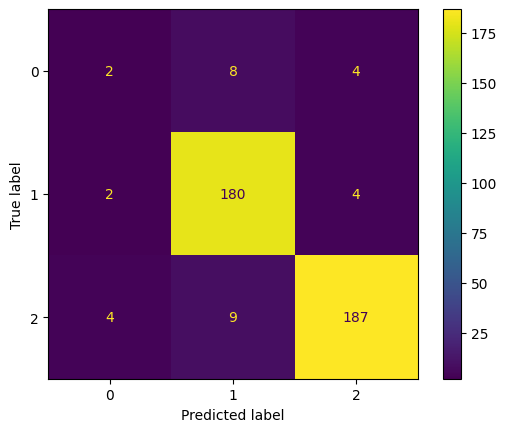

In [ ]:
# ==== DistilBERT metrics on clean test set ====

pred_out = trainer.predict(test_tok)
logits = pred_out.predictions
y_pred_distil = logits.argmax(axis=1)

print("=== DistilBERT (text only) ===")
print(classification_report(y_test, y_pred_distil))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_distil)
plt.show()


<h2 style="border-bottom:3px solid #22c55e; padding-bottom:4px;">
💾 Step 3 – Persist DistilBERT and compute test probabilities
</h2>

<p>
We now:
</p>

<ul>
  <li>Save the fine-tuned DistilBERT model and tokenizer to
      <code>Models/&lt;DATASET_TAG&gt;/distilbert-email-final/</code>.</li>
  <li>Apply a softmax to the test logits to obtain a
      <code>proba_distil_test</code> matrix of shape <code>(N_test, 3)</code>.</li>
</ul>

<p>
These probabilities will later be used in the <strong>deep ensemble</strong> alongside the domain-based LightGBM model.
</p>


In [ ]:
# ==== Save DistilBERT model & tokenizer for reuse ====

distil_final_dir = os.path.join(MODEL_DIR, "distilbert-email-final")
os.makedirs(distil_final_dir, exist_ok=True)

distil_model.save_pretrained(distil_final_dir)
tokenizer.save_pretrained(distil_final_dir)


('/content/drive/MyDrive/COSC 4371 - Security Analytics/Adversial Machine Learning - Phishing Email Classifier/Datasets/Models/emails_after2010_balanced/distilbert-email-final/tokenizer_config.json',
 '/content/drive/MyDrive/COSC 4371 - Security Analytics/Adversial Machine Learning - Phishing Email Classifier/Datasets/Models/emails_after2010_balanced/distilbert-email-final/special_tokens_map.json',
 '/content/drive/MyDrive/COSC 4371 - Security Analytics/Adversial Machine Learning - Phishing Email Classifier/Datasets/Models/emails_after2010_balanced/distilbert-email-final/vocab.txt',
 '/content/drive/MyDrive/COSC 4371 - Security Analytics/Adversial Machine Learning - Phishing Email Classifier/Datasets/Models/emails_after2010_balanced/distilbert-email-final/added_tokens.json',
 '/content/drive/MyDrive/COSC 4371 - Security Analytics/Adversial Machine Learning - Phishing Email Classifier/Datasets/Models/emails_after2010_balanced/distilbert-email-final/tokenizer.json')

In [ ]:
# softmax to get probabilities
proba_distil_test = np.exp(logits) / np.exp(logits).sum(axis=1, keepdims=True)
proba_distil_test.shape


(400, 3)

<h2 style="border-bottom:3px solid #8b5cf6; padding-bottom:4px;">
🌐 Step 4 – Attach RDAP/DNS + age features to each email
</h2>

<p>
We bring in the <strong>precomputed domain-level features</strong> for this <code>DATASET_TAG</code>:
</p>

<ul>
  <li>Load <code>sender_domain_rdapdns_features_&lt;DATASET_TAG&gt;.csv</code>.</li>
  <li>Merge these features into the email DataFrame via <code>sender_domain</code>.</li>
  <li>Recompute <strong>domain age at send time</strong> and binary flags for “new within 30/90 days”.</li>
  <li>Build <code>X_domain_all</code> (11 numeric RDAP/DNS + age features per email).</li>
  <li>Align <code>X_train_domain</code> / <code>X_test_domain</code> with the same indices used for text.</li>
</ul>

<p>
These features encode infrastructure behavior that complements what DistilBERT sees in the text.
</p>


In [ ]:
# ==== Load precomputed domain-level RDAP/DNS features ====

domain_feat_path = os.path.join(DATA_PATH, f"sender_domain_rdapdns_features_{DATASET_TAG}.csv")
domain_features_df = pd.read_csv(domain_feat_path)


# Merge into combined to get per-email RDAP/DNS features
df = combined.copy()
df = df.merge(domain_features_df, on="sender_domain", how="left")

# Ensure consistent datetime
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df["domain_creation_date"] = pd.to_datetime(df["domain_creation_date"], errors="coerce")

# Domain age at time of email (days)
df["domain_age_days_at_email"] = (df["date"] - df["domain_creation_date"]).dt.days

df["domain_is_new_30d"] = (
    (df["domain_age_days_at_email"] >= 0)
    & (df["domain_age_days_at_email"] <= 30)
).astype(int)

df["domain_is_new_90d"] = (
    (df["domain_age_days_at_email"] >= 0)
    & (df["domain_age_days_at_email"] <= 90)
).astype(int)


In [ ]:
# ==== Select RDAP/DNS feature columns ====

domain_cols = [
    "rdap_exists",
    "rdap_has_active_status",
    "rdap_has_hold_status",
    "dns_a_count",
    "dns_mx_count",
    "dns_ns_count",
    "dns_txt_count",
    "has_mx",
    "domain_age_days_at_email",
    "domain_is_new_30d",
    "domain_is_new_90d",
]

for col in domain_cols:
    if col not in df.columns:
        df[col] = 0
    else:
        df[col] = df[col].fillna(0)

X_domain_all = df[domain_cols].astype(float)
y_all = df["label_3class"].astype(int)



# Use the indices from the original split (X_train_text / X_test_text)
X_train_domain = X_domain_all.loc[X_train_text.index]
X_test_domain  = X_domain_all.loc[X_test_text.index]

X_train_domain.shape, X_test_domain.shape


((1600, 11), (400, 11))

<h2 style="border-bottom:3px solid #0ea5e9; padding-bottom:4px;">
📏 Step 5 – Build a joint text+domain feature space for anomaly detection
</h2>

<p>
To feed a One-Class SVM, we create a dense feature representation that mixes
<strong>text patterns</strong> and <strong>domain signals</strong>:
</p>

<ul>
  <li>Load the TF-IDF vectorizer from the Base Pipeline for this <code>DATASET_TAG</code>
      (or recreate it if missing).</li>
  <li>Transform train/test text into high-dim TF-IDF matrices.</li>
  <li>Use <code>TruncatedSVD</code> to reduce text to 100-dim embeddings.</li>
  <li>Standardize both text embeddings and RDAP/DNS features.</li>
  <li>Concatenate them into <code>X_train_combined</code> / <code>X_test_combined</code>.</li>
</ul>

<p>
This joint feature space lets the One-Class SVM learn what “normal HAM” looks like in both content and infrastructure.
</p>


In [ ]:
# ==== Load existing TF-IDF vectorizer from base pipeline ====
tfidf_filename = f"tfidf_vectorizer_{DATASET_TAG}.joblib"
tfidf_path = os.path.join(MODEL_DIR, tfidf_filename)
tfidf = joblib.load(tfidf_path)


X_train_tfidf = tfidf.transform(X_train_text)
X_test_tfidf  = tfidf.transform(X_test_text)

X_train_tfidf.shape, X_test_tfidf.shape


((1600, 50000), (400, 50000))

In [ ]:
# ==== Dimensionality reduction for text (SVD) ====
svd = TruncatedSVD(n_components=100, random_state=SEED)
X_train_text_emb = svd.fit_transform(X_train_tfidf)
X_test_text_emb  = svd.transform(X_test_tfidf)

print(X_train_text_emb.shape, X_test_text_emb.shape)


(1600, 100) (400, 100)


In [ ]:
# ==== Scale text and RDAP/DNS features ====
scaler_text = StandardScaler()
scaler_domain = StandardScaler()

X_train_text_scaled   = scaler_text.fit_transform(X_train_text_emb)
X_test_text_scaled    = scaler_text.transform(X_test_text_emb)

X_train_domain_scaled = scaler_domain.fit_transform(X_train_domain)
X_test_domain_scaled  = scaler_domain.transform(X_test_domain)

# Combined feature space for OC-SVM
X_train_combined = np.hstack([X_train_text_scaled, X_train_domain_scaled])
X_test_combined  = np.hstack([X_test_text_scaled,  X_test_domain_scaled])

X_train_combined.shape, X_test_combined.shape


((1600, 111), (400, 111))

<h2 style="border-bottom:3px solid #facc15; padding-bottom:4px;">
🚨 Step 6 – One-Class SVM anomaly detector on HAM
</h2>

<p>
We now treat <strong>HAM as “normal”</strong> and everything else as potential anomalies:
</p>

<ul>
  <li>Filter <code>X_train_combined</code> down to HAM only and train a <code>OneClassSVM</code> with RBF kernel.</li>
  <li>Evaluate on the test set as a <strong>binary</strong> problem (ham vs anomaly).</li>
  <li>Compute <code>decision_function</code> scores, where higher = more normal-looking.</li>
  <li>Save the SVD, scalers, and OC-SVM model for future reuse.</li>
</ul>

<p>
These anomaly scores will become an extra feature channel for the downstream LightGBM classifier.
</p>


In [ ]:
# ==== Train One-Class SVM on HAM only ====

ham_mask = (y_train == 0)
X_train_ham = X_train_combined[ham_mask.values]

print("Total train samples:", len(y_train))
print("HAM train samples:", X_train_ham.shape[0])

ocsvm = OneClassSVM(
    kernel="rbf",
    gamma="scale",
    nu=0.05,
)
ocsvm.fit(X_train_ham)


Total train samples: 1600
HAM train samples: 56


OneClassSVM(nu=0.05)

=== One-Class SVM (text + RDAP/DNS) ===
              precision    recall  f1-score   support

     anomaly       0.99      0.75      0.85       386
         ham       0.11      0.86      0.20        14

    accuracy                           0.75       400
   macro avg       0.55      0.80      0.52       400
weighted avg       0.96      0.75      0.83       400



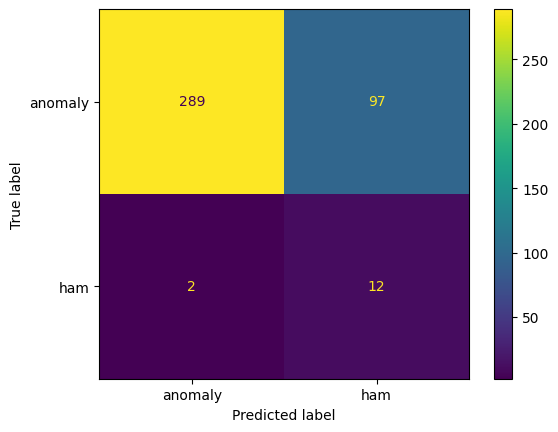

In [ ]:
# ==== OC-SVM: anomaly evaluation (binary: ham vs anomaly) ====

y_test_binary = np.where(y_test == 0, "ham", "anomaly")

oc_test_raw = ocsvm.predict(X_test_combined)        # +1 inlier, -1 outlier
oc_pred_binary = np.where(oc_test_raw == 1, "ham", "anomaly")

print("=== One-Class SVM (text + RDAP/DNS) ===")
print(classification_report(y_test_binary, oc_pred_binary))

ConfusionMatrixDisplay.from_predictions(y_test_binary, oc_pred_binary)
plt.show()


In [ ]:
# ==== OC-SVM decision scores (higher=more normal) ====

oc_train_scores = ocsvm.decision_function(X_train_combined).reshape(-1, 1)
oc_test_scores  = ocsvm.decision_function(X_test_combined).reshape(-1, 1)

oc_train_scores.shape, oc_test_scores.shape


((1600, 1), (400, 1))

In [ ]:
# ==== Save OC-SVM pieces for reuse ====
joblib.dump(svd,          os.path.join(MODEL_DIR, "svd_tfidf_100d.joblib"))
joblib.dump(scaler_text,  os.path.join(MODEL_DIR, "scaler_text_embeddings.joblib"))
joblib.dump(scaler_domain,os.path.join(MODEL_DIR, "scaler_domain_features.joblib"))
joblib.dump(ocsvm,        os.path.join(MODEL_DIR, "ocsvm_text_domain.joblib"))


['/content/drive/MyDrive/COSC 4371 - Security Analytics/Adversial Machine Learning - Phishing Email Classifier/Datasets/Models/emails_after2010_balanced/ocsvm_text_domain.joblib']

<h2 style="border-bottom:3px solid #fb7185; padding-bottom:4px;">
🌱 Step 7 – LightGBM on RDAP/DNS features + anomaly score
</h2>

<p>
Here we build a powerful <strong>domain-side classifier</strong> by combining:
</p>

<ul>
  <li>The per-email RDAP/DNS + age features (<code>X_train_domain</code>, <code>X_test_domain</code>).</li>
  <li>The OC-SVM decision score (how “normal” the email looks as HAM).</li>
</ul>

<p>
We:
</p>

<ul>
  <li>Concatenate these into <code>X_train_lgbm</code> / <code>X_test_lgbm</code>.</li>
  <li>Train a multiclass <code>LGBMClassifier</code> on the 3-class labels.</li>
  <li>Evaluate performance and store <code>proba_lgbm_test</code> for the ensemble.</li>
  <li>Save the trained LightGBM model for this <code>DATASET_TAG</code>.</li>
</ul>


In [ ]:
# ==== Build final LightGBM feature matrices (RDAP/DNS + OC score) ====

X_train_lgbm = np.hstack([X_train_domain.values, oc_train_scores])
X_test_lgbm  = np.hstack([X_test_domain.values,  oc_test_scores])

X_train_lgbm.shape, X_test_lgbm.shape


((1600, 12), (400, 12))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000153 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 372
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 8
[LightGBM] [Info] Start training from score -3.352407
[LightGBM] [Info] Start training from score -0.763033
[LightGBM] [Info] Start training from score -0.695650
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
=== LightGBM (RDAP/DNS + OC-SVM score) ===
              precision    recall  f1-score   support

           0       0.27      0.21      0.24        14
           1       0.50      0.58      0.54       186
           2       0.54      0.47      0.51       200

    accuracy                           0.52       400
   macro avg       0.44      0.42      0.43       400
weighted avg       0.52      0.52      0.51 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


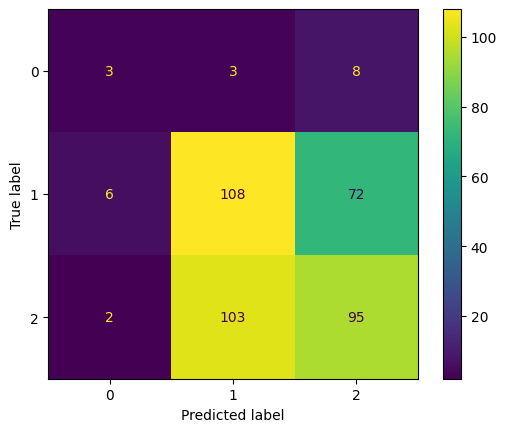

In [ ]:
# ==== Train LightGBM ====

lgbm_deep = LGBMClassifier(
    n_estimators=300,
    learning_rate=0.05,
    num_leaves=31,
    random_state=SEED,
)

lgbm_deep.fit(X_train_lgbm, y_train)

y_pred_lgbm = lgbm_deep.predict(X_test_lgbm)
proba_lgbm_test = lgbm_deep.predict_proba(X_test_lgbm)

print("=== LightGBM (RDAP/DNS + OC-SVM score) ===")
print(classification_report(y_test, y_pred_lgbm))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_lgbm)
plt.show()


In [ ]:
# ==== Save LightGBM model ====
joblib.dump(lgbm_deep, os.path.join(MODEL_DIR, "lightgbm_rdapdns_ocscore_3class.joblib"))


['/content/drive/MyDrive/COSC 4371 - Security Analytics/Adversial Machine Learning - Phishing Email Classifier/Datasets/Models/emails_after2010_balanced/lightgbm_rdapdns_ocscore_3class.joblib']

<h2 style="border-bottom:3px solid #64748b; padding-bottom:4px;">
🧷 Step 8 – Deep ensemble of text and domain models
</h2>

<p>
Finally, we combine the best of both worlds into a <strong>deep ensemble</strong>:
</p>

<ul>
  <li>Align DistilBERT and LightGBM probability outputs to a common class order <code>[0,1,2]</code>.</li>
  <li>Average the probability vectors (soft voting, equal weights).</li>
  <li>Take the <code>argmax</code> to obtain final deep-ensemble predictions.</li>
</ul>

<p>
This ensemble leverages:
</p>

<ul>
  <li><strong>Contextual understanding</strong> of the email text from DistilBERT.</li>
  <li><strong>Infrastructure + anomaly signals</strong> from LightGBM (RDAP/DNS + OC-SVM score).</li>
</ul>

<p>
Because all components are driven by <code>DATASET_TAG</code>, this same structure applies cleanly
to pre-2010, post-2010, synthetic, and any combined datasets.
</p>


=== Deep Ensemble (DistilBERT + LightGBM[RDAP/DNS + OC score]) ===
              precision    recall  f1-score   support

           0       0.50      0.14      0.22        14
           1       0.92      0.97      0.94       186
           2       0.94      0.94      0.94       200

    accuracy                           0.93       400
   macro avg       0.79      0.69      0.70       400
weighted avg       0.92      0.93      0.92       400



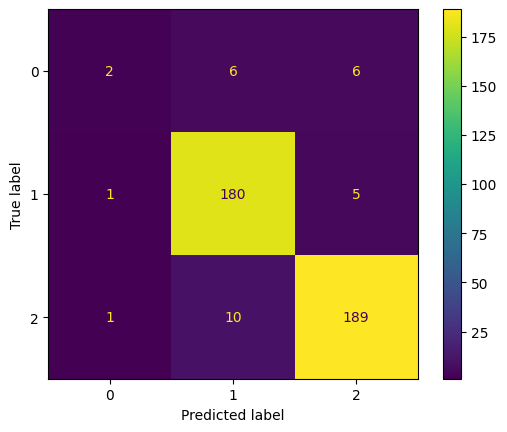

In [ ]:
# ==== Deep ensemble: soft-vote DistilBERT + LightGBM ====

classes_all = np.array(sorted(np.unique(y_train)))  # [0,1,2]

def align_proba(proba, clf_classes, classes_all):
    """Align columns of 'proba' to global class order classes_all."""
    out = np.zeros((proba.shape[0], len(classes_all)))
    for i, c in enumerate(clf_classes):
        j = np.where(classes_all == c)[0][0]
        out[:, j] = proba[:, i]
    return out

# DistilBERT: we know labels are 0,1,2 already, but keep it explicit
distil_classes = classes_all

proba_distil_aligned = align_proba(proba_distil_test, distil_classes, classes_all)
proba_lgbm_aligned   = align_proba(proba_lgbm_test, lgbm_deep.classes_, classes_all)

# Soft vote (equal weights for now)
proba_deep_ens = (proba_distil_aligned + proba_lgbm_aligned) / 2.0

y_pred_deep_ens = classes_all[np.argmax(proba_deep_ens, axis=1)]


print("=== Deep Ensemble (DistilBERT + LightGBM[RDAP/DNS + OC score]) ===")
print(classification_report(y_test, y_pred_deep_ens))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_deep_ens)
plt.show()


In [ ]:
# ==== Save predictions for final comparison notebook ====

np.save(os.path.join(DATA_PATH, f"y_test_deep_{DATASET_TAG}.npy"),          y_test.to_numpy())
np.save(os.path.join(DATA_PATH, f"y_pred_distil_deep_{DATASET_TAG}.npy"),   y_pred_distil)
np.save(os.path.join(DATA_PATH, f"y_pred_lgbm_deep_{DATASET_TAG}.npy"),     y_pred_lgbm)
np.save(os.path.join(DATA_PATH, f"y_pred_deep_ens_{DATASET_TAG}.npy"),      y_pred_deep_ens)
